In [1]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 28.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
from sqlalchemy import create_engine
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns
import warnings
from tensorflow.keras.utils import plot_model
warnings.filterwarnings('ignore')
from datetime import timedelta, date, datetime
import time
import matplotlib.ticker as tkr
from scipy import stats
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
from sklearn.preprocessing import MinMaxScaler
matplotlib.rcParams['text.color'] = 'k'
from pylab import rcParams
from statsmodels.tsa.seasonal import STL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras import optimizers

%matplotlib inline

In [3]:
from google.colab import files
import io
uploaded = files.upload()

Saving Global DataBase2 daily.csv to Global DataBase2 daily.csv
Saving Global DataBase3.csv to Global DataBase3.csv


In [4]:
df1=pd.read_csv(io.BytesIO(uploaded['Global DataBase2 daily.csv']), index_col='datetime_per_day', parse_dates=True, dayfirst =True)

df2=pd.read_csv(io.BytesIO(uploaded['Global DataBase3.csv']), index_col='datetime', parse_dates=True, dayfirst = True )



df1 = df1.loc['2017-01-01':'2020-12-31']
df2 = df2.loc['2017-01-01':'2020-12-31']

index = pd.date_range(start='2017-01-01', end='2022-02-28', freq="1d")
columns = ["datetime_per_week", 'Price - PT [€/MWh]','Price - ES [€/MWh]','Actual Consumption (MWh)','Biomass AA','Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA','Wind Onshore AA','Electricity Consumption (MWh)']

df = pd.DataFrame(np.nan, index=range(0,index.size), columns=columns)
df["datetime_per_week"] = index
df.set_index("datetime_per_week", inplace=True)

df = df.resample("W").mean()


columns1 = ['Electricity Consumption (MWh)']
for column in columns1 : 
    df[column] = df2[column].resample("W").sum()
columns2=['Price - PT [€/MWh]','Price - ES [€/MWh]','Actual Consumption (MWh)','Biomass AA','Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA','Wind Onshore AA']
for column in columns2 : 
    df[column] = df2[column].resample("W").mean()
df = df.sort_index()

#Handeling global outliers
GlobalOutliers =  []
for i in range(13):
    GlobalOutliers.append(df.idxmax()['Price - PT [€/MWh]'])
    df.at[df.idxmax()['Price - PT [€/MWh]'], 'Price - PT [€/MWh]'] = np.nan

#Replacing them with the mean of that day
for d in GlobalOutliers:
    sdt = datetime.combine(d, datetime.min.time())
    edt = sdt + timedelta(hours=24)
    df.at[d, 'Price - PT [€/MWh]'] = df[sdt:edt]['Price - PT [€/MWh]'].mean()
    
#Handling negative values 
negativeIndex = df.index[df['Price - PT [€/MWh]'] < 0]
for index in (negativeIndex):
    df.at[index, 'Price - PT [€/MWh]']= df.at[index - timedelta(hours=1), 'Price - PT [€/MWh]']
    
df = df.dropna()


In [5]:
df = df.reset_index(level=0)

In [6]:
df["Date Time"] = pd.to_datetime(df['datetime_per_week'])

In [7]:
df["Day"] = df["Date Time"].dt.day
df["Month"] = df["Date Time"].dt.month
df["Year"] = df["Date Time"].dt.day
df["Hour"] = df["Date Time"].dt.hour
df["Minute"] = df["Date Time"].dt.minute
df["Demand"] = pd.to_numeric(df['Price - PT [€/MWh]'], errors = 'coerce')

In [8]:
df

,datetime_per_week,Price - PT [€/MWh],Price - ES [€/MWh],Actual Consumption (MWh),Biomass AA,Fossil Gas AA,Fossil Hard Coal AC,Hydro Pumped Storage AA,Hydro Pumped Storage AC,Hydro Run-of-river and poundage AA,...,Solar AA,Wind Onshore AA,Electricity Consumption (MWh),Date Time,Day,Month,Year,Hour,Minute,Demand
0,2017-01-01,51.42,51.05,4875.13,351.65,1138.83,0.00,137.17,402.09,405.70,...,56.61,651.48,112128.00,2017-01-01,1,1,1,0,0,51.42
1,2017-01-08,63.97,63.72,4915.58,348.82,1986.83,3.25,451.32,313.36,612.48,...,49.77,1461.74,825818.00,2017-01-08,8,1,8,0,0,63.97
2,2017-02-05,54.93,54.98,4915.58,336.87,1330.31,1.93,483.24,264.86,666.31,...,45.31,2942.16,825818.00,2017-02-05,5,2,5,0,0,54.93
3,2017-02-12,54.04,54.76,4915.58,343.85,1664.58,2.71,426.09,178.42,930.31,...,58.43,2223.01,825818.00,2017-02-12,12,2,12,0,0,54.04
4,2017-02-19,53.95,54.40,4915.58,345.56,1910.82,2.70,328.98,164.76,1062.73,...,84.17,1435.14,825818.00,2017-02-19,19,2,19,0,0,53.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,2020-12-06,47.03,47.15,4915.58,394.95,2225.34,16.52,370.63,145.03,1025.46,...,100.35,1949.52,825818.00,2020-12-06,6,12,6,0,0,47.03
193,2020-12-13,39.04,39.04,4915.58,395.98,1051.33,13.71,538.90,361.02,882.39,...,42.43,2789.64,825818.00,2020-12-13,13,12,13,0,0,39.04
194,2020-12-20,48.42,48.37,4915.58,380.27,1878.88,12.51,514.38,194.58,1492.29,...,79.22,1535.10,825818.00,2020-12-20,20,12,20,0,0,48.42
195,2020-12-27,36.81,36.55,4915.58,391.35,829.35,14.36,489.07,460.82,980.67,...,118.57,1961.43,825818.00,2020-12-27,27,12,27,0,0,36.81


In [9]:
columns = ['datetime_per_week','Date Time', 'Price - PT [€/MWh]', 'Price - ES [€/MWh]','Actual Consumption (MWh)', 'Biomass AA', 'Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC', 'Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA', 'Wind Onshore AA','Electricity Consumption (MWh)']
for column in columns :
  df.drop([column],  axis=1, inplace=True )

In [10]:
X= []
y= []

In [11]:
for i in range(0, df.shape[0]-10):
    X.append(df.iloc[i:i+10,5])
    y.append(df.iloc[i+10,5])
    
X, y = np.array(X), np.array(y)
y = np.reshape(y, (len(y), 1))

In [12]:
pd.DataFrame(X).to_csv('appended_Demand.csv')
pd.DataFrame(y).to_csv('appended_Demand_1.csv')

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))

X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [14]:
#split
size = int(len(df)*0.8)
           
X_train, X_test = X[:size], X[size:]
y_train, y_test = y[:size], y[size:]

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [16]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

filepath ='models/MODEL.hdf5'

callbacks = [EarlyStopping(monitor='val_loss',patience=50),
            ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')]

optimizers.Adam(lr=0.0001)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [17]:
start_time = time.time()

history = model.fit(X_train, y_train, validation_split=0.1, epochs=1000, callbacks=callbacks, batch_size=20)

exec_time = time.time()-start_time

Epoch 1/1000
8/8 [==============================] - 9s 134ms/step - loss: 0.2249 - mae: 0.4260 - val_loss: 0.0748 - val_mae: 0.2396
Epoch 2/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.0459 - mae: 0.1796 - val_loss: 0.0565 - val_mae: 0.2050
Epoch 3/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0262 - mae: 0.1330 - val_loss: 0.0319 - val_mae: 0.1545
Epoch 4/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0206 - mae: 0.1132 - val_loss: 0.0739 - val_mae: 0.2384
Epoch 5/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.0169 - mae: 0.0950 - val_loss: 0.0594 - val_mae: 0.2099
Epoch 6/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0161 - mae: 0.0996 - val_loss: 0.0499 - val_mae: 0.1918
Epoch 7/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.0146 - mae: 0.0892 - val_loss: 0.0710 - val_mae: 0.2331
Epoch 8/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0152 - m

In [18]:
model.load_weights("models/MODEL.hdf5")

In [19]:
yhat = model.predict(X_test)

In [20]:
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(y_test)

In [21]:
from sklearn import metrics
#Calculate MAE, MSE, RMSE, CV
MAE= metrics.mean_absolute_error(inv_y, inv_yhat)
MSE=metrics.mean_squared_error(inv_y, inv_yhat)
CV= (np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))/inv_y.mean())*100
R2= metrics.r2_score(inv_y, inv_yhat)

print('Mean Absolute Error:', MAE)
print('Mean Squared Error:', MSE)  
print('Root Mean Squared Error:', np.sqrt(MSE))
print('Coefficient of Variance:',CV)
print('R2:', R2)
print('exec_time:', exec_time)

Mean Absolute Error: 2.971047040666851
Mean Squared Error: 14.554377145453067
Root Mean Squared Error: 3.8150199403742397
Coefficient of Variance: 10.040715059859998
R2: 0.3980113033559173
exec_time: 28.089934825897217


In [22]:
inv_y.shape

(30, 1)

[Text(0, 0.5, 'Price [€/MWh]'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, "Prix de l'éléctricité au Portugal")]

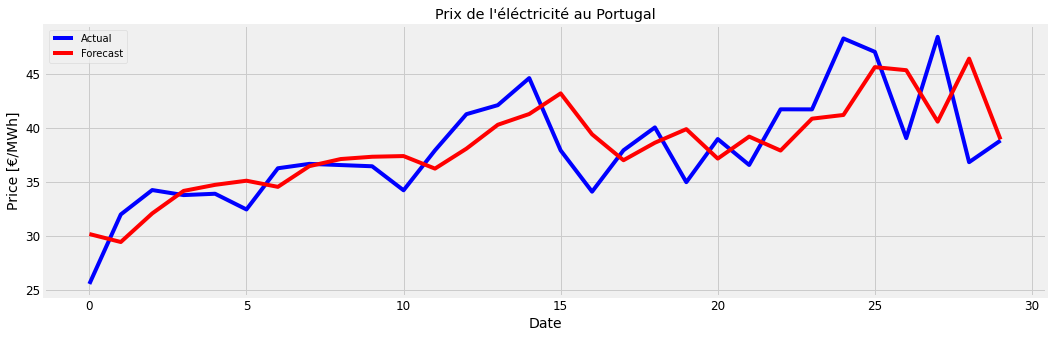

In [24]:
plt.figure(figsize=(16,5))
plt.plot(df.index[:42], inv_y, color='blue')
plt.plot(df.index[:42], inv_yhat, color='red')
plt.legend(('Actual', 'Forecast'))
plt.gca().set(title="Prix de l'éléctricité au Portugal", xlabel='Date', ylabel='Price [€/MWh]')

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True )

In [ ]:
# plot history
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.gca().set(title='Courbes d\'apprentissage .', xlabel='Epochs', ylabel='Erreur')
plt.legend()

In [ ]:
import time

for i in range(0, X_test.shape[0]):
    demand_summary = []
    X_input = X_test[i,:,:]
    X_input = np.reshape(X_input, (1, X_input.shape[0], 1))
    X_input = model.predict(X_input)
    forecast = scaler.inverse_transform(X_input)
    
    
    y_input = y_test[i,:]
    y_input = np.reshape(y_input, (1,1))
    actual = scaler.inverse_transform(y_input)
    
    demand_summary.append(actual)
    demand_summary.extend(forecast)
    
    df_animate = pd.DataFrame(demand_summary)
    df_animate = df_animate.T
    df_animate.to_csv('real time demand.csv', mode='a', header=False, index=False)
    
    print(demand_summary)
    time.sleep(2)